In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import sys
from PIL import Image
from io import BytesIO

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

import multiprocessing

import joblib

#_____________

N_IMAGES = 111430
N_IMAGES_TEST = 10130

# Prepare the data

### images (training set)

In [2]:
images = []
n=9408 # each image is composed of 56*56*3 = 9408 bytes
path = "db_train.raw"

with open(path, "rb") as f: # opening a binary file in read mode
    content = f.read() # read all bytes
    print('{} bytes found in the {} file, which represents 56*56*3 bytes for an image times {} images.'.format(len(content), path, N_IMAGES))
    
    for i in range (N_IMAGES) :
        img = Image.frombytes('RGB', (56,56), content[n*i:n*(i+1)], 'raw')
        #img.show()
        images.append(np.array(img))

images = np.array(images)

assert len(images)==N_IMAGES, "images should contain {} elements, as the training set contains {} images".format(N_IMAGES,N_IMAGES)

1048333440 bytes found in the db_train.raw file, which represents 56*56*3 bytes for an image times 111430 images.


### labels (training set)

In [3]:
labels = []

with open('label_train.txt', 'r') as f:
    for line in f:
        labels.append(int(line.replace("\n","")))
        
labels = np.array(labels)

assert len(labels)==N_IMAGES, "labels should contain {} integers, as the training set contains {} images".format(N_IMAGES,N_IMAGES)

### images (test set)

In [4]:
images_test = []
n=9408
path = "db_test.raw"

with open(path, "rb") as f: # opening a binary file in read mode
    content = f.read() # read all bytes
    
    for i in range (N_IMAGES_TEST) :
        img = Image.frombytes('RGB', (56,56), content[n*i:n*(i+1)], 'raw')
        images_test.append(np.array(img))
        
images_test = np.array(images_test)

assert len(images_test)==N_IMAGES_TEST, "images_test should contain {} elements, as the test set contains {} images".format(N_IMAGES_TEST,N_IMAGES_TEST)

# Data visualization

### class distribution

In [5]:
import seaborn as sns
sns.set_theme()

customized_palette = [sns.color_palette()[0], sns.color_palette()[1]]

Amongst a total of 111430 images in the training set :
- class 0 contains 15250 images (13.7%)
- class 1 contains 96180 images (86.3%).



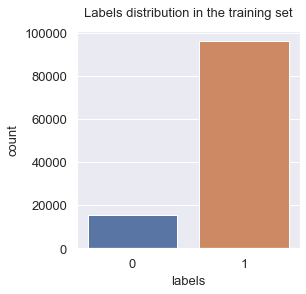

In [6]:
values, counts = np.unique(labels, return_counts=True)
print("Amongst a total of {} images in the training set :\n- class 0 contains {} images ({}%)\n- class 1 contains {} images ({}%).\n".format(N_IMAGES,
                                                                                                                                           counts[0],
                                                                                                                                           round(100*counts[0]/N_IMAGES,1),
                                                                                                                                           counts[1],
                                                                                                                                           round(100*counts[1]/N_IMAGES,1)))

plt.figure(figsize=(4,4))

ax = sns.countplot(x=labels, palette=customized_palette)

ax.set_xlabel('labels', fontsize=13, labelpad=5)
ax.set_ylabel('count', fontsize=13, labelpad=5)
ax.tick_params(axis='both', labelsize=13)
ax.set_title('Labels distribution in the training set', fontsize=13, pad=15)

plt.show()

Observation :

There is a big difference in the distribution of the images between the 2 classes.

### classification criterion

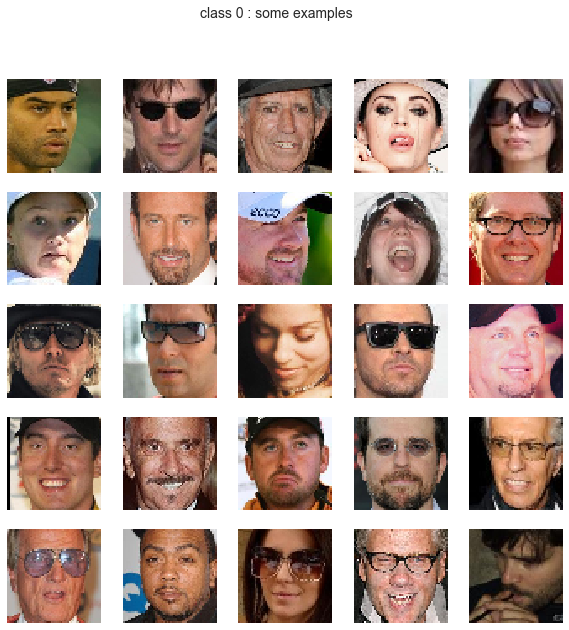

In [7]:
# Display some images labeled as 0

arg_labels_0 = np.argwhere(labels==0)
arg_labels_0 = np.reshape(arg_labels_0, newshape=len(arg_labels_0))

fig,ax = plt.subplots(nrows=5, ncols=5, figsize=(10,10)) 
#fig.subplots_adjust(0,0,3,3)
k=0

for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[arg_labels_0[k]])
        ax[i,j].axis('off')
        k+=1

fig.suptitle('class 0 : some examples', fontsize=14)
plt.show()

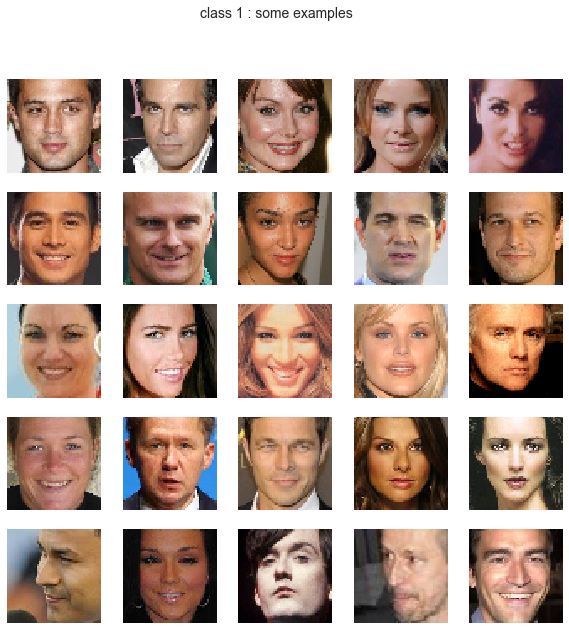

In [8]:
# Display some images labeled as 1

arg_labels_1 = np.argwhere(labels==1)
arg_labels_1 = np.reshape(arg_labels_1, newshape=len(arg_labels_1))

fig,ax = plt.subplots(nrows=5, ncols=5, figsize=(10,10)) 
k=0

for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[arg_labels_1[k]])
        ax[i,j].axis('off')
        k+=1
        
fig.suptitle('class 1 : some examples', fontsize=14)
plt.show()

Observation :

I suspect the dataset to be extracted from the CelebA dataset ([link](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)) : a famous dataset that contains images of celebrity faces, with 40 different attributes for each image.<br/><br/>
The list of attributes is as follows :<br/>
5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young

In my opinion, the class 0 contains images that have specific attributes : Eyeglasses, Mustache, Wearing_Hat (and maybe a few more that I haven't spotted)

# Split training set / test set

In this case study, we have quite a lot of data (111430 images), so we can keep 80% for our training (and validation) set, and only 20% for the test set, which represents already lots of images.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=42, shuffle=True)

Amongst a total of 89144 images in the new training set :
- class 0 contains 12140 images (13.6%)
- class 1 contains 77004 images (86.4%).

Amongst a total of 22286 images in the new test set :
- class 0 contains 3110 images (14.0%)
- class 1 contains 19176 images (86.0%).



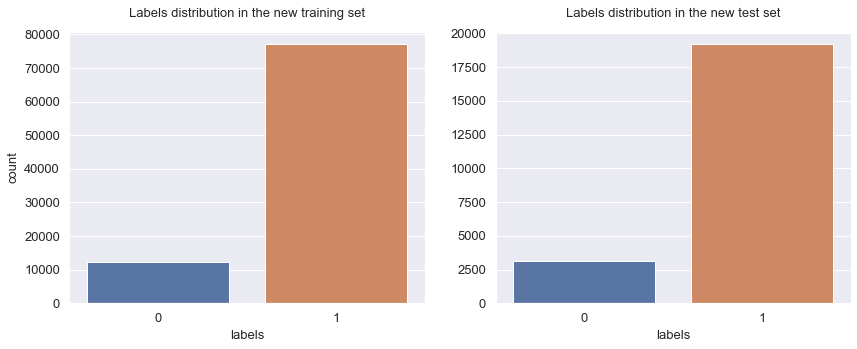

In [10]:
values, counts = np.unique(y_train, return_counts=True)
print("Amongst a total of {} images in the new training set :\n- class 0 contains {} images ({}%)\n- class 1 contains {} images ({}%).\n".format(len(y_train),
                                                                                                                                           counts[0],
                                                                                                                                           round(100*counts[0]/len(y_train),1),
                                                                                                                                           counts[1],
                                                                                                                                           round(100*counts[1]/len(y_train),1)))

values, counts = np.unique(y_test, return_counts=True)
print("Amongst a total of {} images in the new test set :\n- class 0 contains {} images ({}%)\n- class 1 contains {} images ({}%).\n".format(len(y_test),
                                                                                                                                           counts[0],
                                                                                                                                           round(100*counts[0]/len(y_test),1),
                                                                                                                                           counts[1],
                                                                                                                                           round(100*counts[1]/len(y_test),1)))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

sns.countplot(x=y_train, ax=axes[0], palette=customized_palette)
sns.countplot(x=y_test, ax=axes[1], palette=customized_palette)

axes[0].set_xlabel('labels', fontsize=13, labelpad=5)
axes[0].set_ylabel('count', fontsize=13, labelpad=5)
axes[0].tick_params(axis='both', labelsize=13)
axes[0].set_title('Labels distribution in the new training set', fontsize=13, pad=15)

axes[1].set_xlabel('labels', fontsize=13, labelpad=5)
axes[1].set_ylabel('', fontsize=13, labelpad=5)
axes[1].tick_params(axis='both', labelsize=13)
axes[1].set_title('Labels distribution in the new test set', fontsize=13, pad=15)

plt.show()

We see that the labels distribution is similar to the initial distribution which was class 0 : 13.7% and class 1 : 86.3%.

# Preprocessing

### normalization

In [11]:
# Training set
print('[Originally] images are of type {} with values ranging from {} to {}.\n'.format(X_train.dtype, X_train.min(), X_train.max()))

X_train = X_train.astype('float32')
X_train /= 255.0
print('[After normalization] images are of type {} with values ranging from {} to {}'.format(X_train.dtype, X_train.min(), X_train.max()))

# 'False' test set
X_test = X_test.astype('float32')
X_test /= 255.0

# 'Real' test set
images_test = images_test.astype('float32')
images_test /= 255.0

[Originally] images are of type uint8 with values ranging from 0 to 255.

[After normalization] images are of type float32 with values ranging from 0.0 to 1.0


### split training set / validation set

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42, shuffle=True)

Amongst a total of 71315 images in the new training set :
- class 0 contains 9698 images (13.6%)
- class 1 contains 61617 images (86.4%).

Amongst a total of 17829 images in the validation set :
- class 0 contains 2442 images (13.7%)
- class 1 contains 15387 images (86.3%).



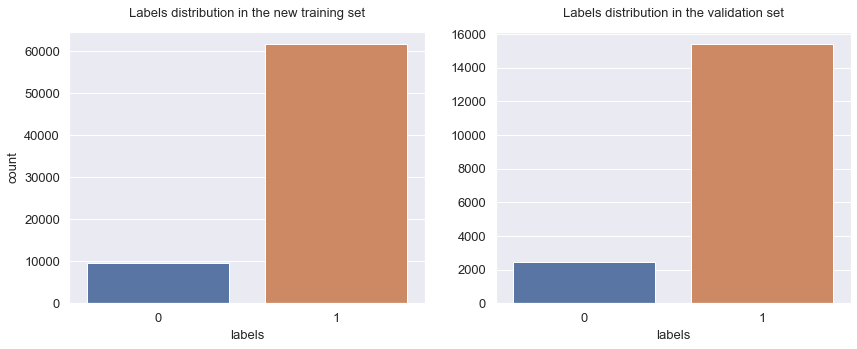

In [13]:
values, counts = np.unique(y_train, return_counts=True)
print("Amongst a total of {} images in the new training set :\n- class 0 contains {} images ({}%)\n- class 1 contains {} images ({}%).\n".format(len(y_train),
                                                                                                                                           counts[0],
                                                                                                                                           round(100*counts[0]/len(y_train),1),
                                                                                                                                           counts[1],
                                                                                                                                           round(100*counts[1]/len(y_train),1)))

values, counts = np.unique(y_valid, return_counts=True)
print("Amongst a total of {} images in the validation set :\n- class 0 contains {} images ({}%)\n- class 1 contains {} images ({}%).\n".format(len(y_valid),
                                                                                                                                           counts[0],
                                                                                                                                           round(100*counts[0]/len(y_valid),1),
                                                                                                                                           counts[1],
                                                                                                                                           round(100*counts[1]/len(y_valid),1)))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

sns.countplot(x=y_train, ax=axes[0], palette=customized_palette)
sns.countplot(x=y_valid, ax=axes[1], palette=customized_palette)

axes[0].set_xlabel('labels', fontsize=13, labelpad=5)
axes[0].set_ylabel('count', fontsize=13, labelpad=5)
axes[0].tick_params(axis='both', labelsize=13)
axes[0].set_title('Labels distribution in the new training set', fontsize=13, pad=15)

axes[1].set_xlabel('labels', fontsize=13, labelpad=5)
axes[1].set_ylabel('', fontsize=13, labelpad=5)
axes[1].tick_params(axis='both', labelsize=13)
axes[1].set_title('Labels distribution in the validation set', fontsize=13, pad=15)

plt.show()

To compensate the difference of examples between the 2 classes, we will use data augmentation on images labeled as 0 in the training set so our model has more data to find relevant features that differenciate between class 0 and 1.

### data augmentation

In [1]:
from skimage.filters import gaussian

def data_augmentation(img, n=5):
    """
    Creates n transformed images by randomly modifying the horizontal flip,
    brightness, contrast and blur of a reference image.

    Parameters
    ----------
    img : numpy ndarray
        reference image
    n : int
        number of transformed images to create from the original one
    
    Returns
    -------
    list
        a list of n images
    """
    imgs = []
    for i in range (n) :
        img_copy = img.copy()
        
        # Horizontal flip
        h_flip = np.random.randint(2)
        if h_flip :
            img_copy = np.flip(img_copy, axis=1)

        # Brightness
        img_copy = tf.image.adjust_brightness(img_copy, delta=np.random.uniform(low=-0.15, high=0.15))

        # Contrast
        img_copy = tf.image.adjust_contrast(img_copy, contrast_factor=np.random.uniform(low=0.8, high=1.2))

        # Gaussian blur
        img_copy = gaussian(img_copy, sigma=np.random.uniform(low=0, high=0.3), multichannel=True)
        
        imgs.append(img_copy)
    
    return imgs

Observation :

Adding a Gaussian blur creates a bias : with this tranformation, images labeled as 0 may be generally more blurry than class 1, while they were not originally.<br/>
This would need to be changed.

In [15]:
arg_labels0_train = np.argwhere(y_train==0)
arg_labels0_train = np.reshape(arg_labels0_train, newshape=len(arg_labels0_train))

imgs_class0_augmented = []
n_imgs = 5

for index in arg_labels0_train :
    imgs_class0_augmented.append(data_augmentation(X_train[index], n=n_imgs))
imgs_class0_augmented = np.array(imgs_class0_augmented)
imgs_class0_augmented = np.reshape(imgs_class0_augmented, (9698*n_imgs, 56, 56, 3)) # 9698 images labeled 0 in the built training set

# Append augmented images and corresponding labels to the built training set
X_train = np.append(X_train, imgs_class0_augmented, axis=0)
y_train = np.append(y_train, np.array([0 for i in range (9698*n_imgs)]))

[Augmented training set] Amongst a total of 119805 images in the augmented training set :
- class 0 contains 58188 images (48.6%)
- class 1 contains 61617 images (51.4%).



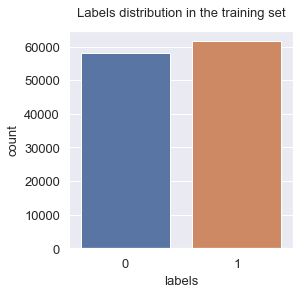

In [16]:
values, counts = np.unique(y_train, return_counts=True)
print("[Augmented training set] Amongst a total of {} images in the augmented training set :\n- class 0 contains {} images ({}%)\n- class 1 contains {} images ({}%).\n".format(counts[0]+counts[1],
                                                                                                                                           counts[0],
                                                                                                                                           round(100*counts[0]/(counts[0]+counts[1]),1),
                                                                                                                                           counts[1],
                                                                                                                                           round(100*counts[1]/(counts[0]+counts[1]),1)))

plt.figure(figsize=(4,4))

ax = sns.countplot(x=y_train, palette=customized_palette)

ax.set_xlabel('labels', fontsize=13, labelpad=5)
ax.set_ylabel('count', fontsize=13, labelpad=5)
ax.tick_params(axis='both', labelsize=13)
ax.set_title('Labels distribution in the training set', fontsize=13, pad=15)

plt.show()

The distribution is now more balanced.

# Useful functions

In [17]:
def create_pred_txt(y_pred):
    """
    Creates a text file with the labels from y_pred

    Parameters
    ----------
    y_pred : list or np.array
        labels predicted by the model
    """
    y_pred_str = []
    for elem in y_pred :
        y_pred_str.append(str(elem) + '\n')

    with open("prediction.txt", "w") as file:
        file.writelines(y_pred_str)

In [18]:
def evaluate(y_pred, y_test):
    """
    Evaluation metric (mean of the errors for each class).

    Parameters
    ----------
    y_pred : list or np.array
        labels predicted by the model
    y_test : list or np.array
        ground truth, labels of the built test set
    """
    assert len(y_pred)==len(y_test), "len(y_pred)={} and len(y_test)={} : the two lists need to be of the same shape".format(len(y_pred),len(y_test))
    values, counts = np.unique(y_test, return_counts=True)
    
    err=[0,0]
    for i in range (len(y_pred)):
        if (y_pred[i] != y_test[i]):
            if (y_test[i] == 0):
                err[0]+=1
            else :
                err[1]+=1
    acc = 0.5*(err[0]/counts[0] + err[1]/counts[1])
    print('class 0 : {} errors for {} images'.format(err[0], counts[0]))
    print('class 1 : {} errors for {} images'.format(err[1], counts[1]))
    print('grade [-100,100] : ', 100.0-200.0*acc)         

# Baseline

In [19]:
#y_pred = np.random.randint(2, size=len(y_test))
y_pred = np.random.choice([0,1], p=[0.137, 0.863], size=len(y_test))
evaluate(y_pred, y_test)

class 0 : 2728 errors for 3110 images
class 1 : 2562 errors for 19176 images
grade [-200,100] :  -1.0774923638470852


# CNN model

### model architecture

I built a CNN composed of three convolutional and pooling layers, followed by two fully connected layers, and ultimately output a probability distribution over the 2 classes.<br/>
The model's architecture is depicted below :

(!! WARNING !! : for readability purposes, the Flatten layer output was set to 300 in the graph, but in reality it is of shape 36x5x5=900, since it flattens the pixels of the precedent layer. A tf.keras.Model.summary() is computed a few cells later for more details.)

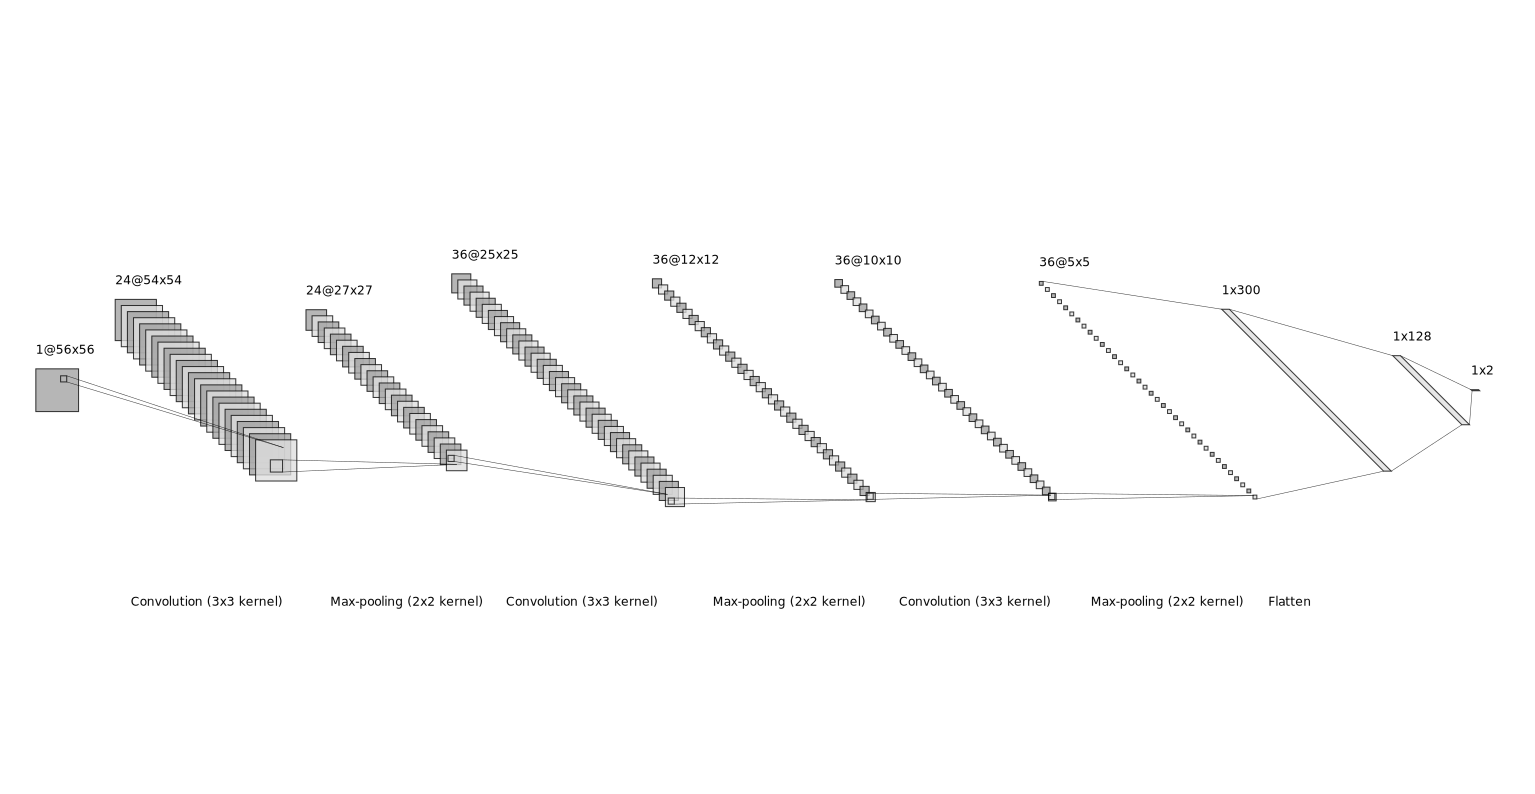

In [20]:
from IPython.display import SVG, display
display(SVG(data='saved_model/model_architecture.svg'))

### build model

In [21]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([

        # first convolutional layer (inputs are 56x56 RGB images)
        tf.keras.layers.Conv2D(filters=24, kernel_size=3, activation=tf.nn.relu, input_shape=(56,56,3), data_format='channels_last'), 

        # first max pooling layer
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

        # second convolutional layer
        tf.keras.layers.Conv2D(filters=36, kernel_size=3, activation=tf.nn.relu),

        # second max pooling layer
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        
        # third convolutional layer
        tf.keras.layers.Conv2D(filters=36, kernel_size=3, activation=tf.nn.relu),

        # third max pooling layer
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),

        # last dense layer to output the classification probabilities
        tf.keras.layers.Dense(2, activation=tf.nn.softmax),
    ])
    
    return cnn_model
  
cnn_model = build_cnn_model()

# initialize the model by passing some data through
cnn_model.predict(X_train[[0]])

# summary of the layers in the model
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 24)        672       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 36)        7812      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 36)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 36)        11700     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 36)          0         
_________________________________________________________________
flatten (Flatten)            (None, 900)               0

In [22]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

### underfitting / overfitting

I already trained the cnn_model on 15 epochs. We'll now load the results (loss and accuracy on the training and validation set) and check if the model overfits and chose the best epochs' parameter.

In [23]:
# Save keras model
#cnn_model.save('test_new_archi-4/cnn_model')

# Load keras model
#cnn_model = tf.keras.models.load_model('saved_model/cnn_model')

#____________

# Dump cnn_model.fit() history (containing accuracy and loss for training and validation set)
#joblib.dump(history.history, 'test_new_archi-4/history.history')

# Load model.fit() history
dict_history = joblib.load('saved_model/history.history')

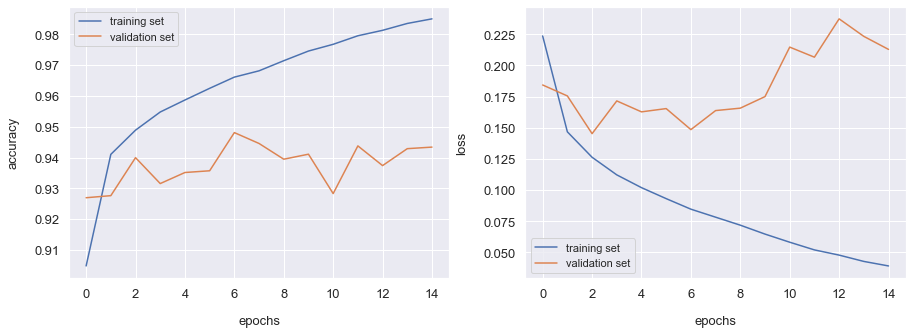

In [24]:
def plot_overfitting(loaded_model, epochs) :
    """
    Plots the accuracy and loss on the training and validation set.

    Parameters
    ----------
    loaded_model : bool
        True if the history and the model were loaded from files, False if the model was trained in this session
        (because the history object differs)
    epochs : int
        number of epochs the model was trained on
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    if (loaded_model) :
        sns.lineplot(x=np.arange(epochs), y=dict_history['accuracy'], label='training set', ax=axes[0])
        sns.lineplot(x=np.arange(epochs), y=dict_history['val_accuracy'], label='validation set', ax=axes[0])
        
        sns.lineplot(x=np.arange(epochs), y=dict_history['loss'], label='training set', ax=axes[1])
        sns.lineplot(x=np.arange(epochs), y=dict_history['val_loss'], label='validation set', ax=axes[1])
        
    else :
        sns.lineplot(x=np.arange(epochs), y=history.history['accuracy'], label='training set', ax=axes[0])
        sns.lineplot(x=np.arange(epochs), y=history.history['val_accuracy'], label='validation set', ax=axes[0])
        
        sns.lineplot(x=np.arange(epochs), y=history.history['loss'], label='training set', ax=axes[1])
        sns.lineplot(x=np.arange(epochs), y=history.history['val_loss'], label='validation set', ax=axes[1])

    axes[0].set_xlabel('epochs', fontsize=13, labelpad=15)
    axes[0].set_ylabel('accuracy', fontsize=13, labelpad=15)
    axes[0].tick_params(axis='both', labelsize=13)

    axes[1].set_xlabel('epochs', fontsize=13, labelpad=15)
    axes[1].set_ylabel('loss', fontsize=13, labelpad=15)
    axes[1].tick_params(axis='both', labelsize=13)

    plt.legend()
    plt.show()

plot_overfitting(loaded_model=True, epochs=15) # the loaded model was trained on 15 epochs

The optimal number of epochs is approximately 5.<br/>
After this point, the loss on the validation set increases again, due to the fact that the model "memorized" the noise and details in the training set to a point where it negatively impacts the performance of the model on new data (= bad generalization).

### train model

In [25]:
BATCH_SIZE = 64
EPOCHS = 5

history = cnn_model.fit(x=X_train, y=y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data = (X_valid, y_valid),
                        workers=multiprocessing.cpu_count())


Epoch 1/5
1872/1872 [==============================] - 479s 256ms/step - loss: 0.3279 - accuracy: 0.8449 - val_loss: 0.2434 - val_accuracy: 0.8980
Epoch 2/5
1872/1872 [==============================] - 515s 275ms/step - loss: 0.1652 - accuracy: 0.9326 - val_loss: 0.1548 - val_accuracy: 0.9372
Epoch 3/5
1872/1872 [==============================] - 532s 284ms/step - loss: 0.1368 - accuracy: 0.9447 - val_loss: 0.1725 - val_accuracy: 0.9282
Epoch 4/5
1872/1872 [==============================] - 519s 277ms/step - loss: 0.1193 - accuracy: 0.9525 - val_loss: 0.1774 - val_accuracy: 0.9267
Epoch 5/5
1872/1872 [==============================] - 470s 251ms/step - loss: 0.1049 - accuracy: 0.9580 - val_loss: 0.1540 - val_accuracy: 0.9401


### predictions

In [26]:
test_loss, test_acc = cnn_model.evaluate(x=X_test, y=y_test, workers=multiprocessing.cpu_count())
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

697/697 [==============================] - 28s 40ms/step - loss: 0.1527 - accuracy: 0.9411
Test accuracy: 0.941084086894989
Test loss: 0.15271040797233582


In [27]:
predictions = cnn_model.predict(X_test)

In [28]:
y_pred = [1 if predictions[i][1]>0.65 else 0 for i in range (len(predictions))]

evaluate(y_pred, y_test)

class 0 : 336 errors for 3110 images
class 1 : 1268 errors for 19176 images
grade [-200,100] :  82.58370927217436


In [29]:
y_pred = np.argmax(predictions, axis=1)

evaluate(y_pred, y_test)

class 0 : 528 errors for 3110 images
class 1 : 785 errors for 19176 images
grade [-200,100] :  78.92884929849342


### overview all predictions

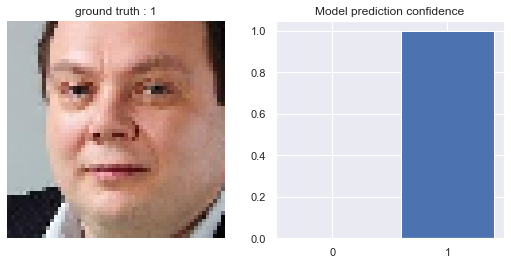

In [30]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def f(image_index):
    # 1st figure
    ax_pred.clear()
    ax_img.imshow(X_test[image_index])
    ax_img.set_title('ground truth : {}'.format(y_test[image_index]))
    
    # 2nd figure
    if (np.argmax(predictions[image_index]) == y_test[image_index]) :
        ax_pred.bar(x=[0,1], height=predictions[image_index], color='green')
        ax_pred.set_title('Model prediction : correct')
    else :
        ax_pred.bar(x=[0,1], height=predictions[image_index], color='red')
        ax_pred.set_title('Model prediction : wrong')
    ax_pred.set_xlabel('labels', fontsize=13, labelpad=5)
    ax_pred.set_ylabel('confidence', fontsize=13, labelpad=5)
    ax_pred.set_xticks([0,1])
    
    # update plot
    fig.canvas.draw()
    display(fig)

    
fig = plt.figure(figsize=(9, 4))
ax_img = fig.add_subplot(121) 
ax_pred = fig.add_subplot(122) 

ax_img.imshow(X_test[0])
ax_img.set_title('ground truth : {}'.format(y_test[0]))
ax_img.axis('off')
ax_pred.bar(x=[0,1], height=predictions[0])
ax_pred.set_title('Model prediction confidence')
ax_pred.set_xticks([0,1])

plt.show()

In [31]:
interact(f, image_index=widgets.IntSlider(min=0,max=50,step=1,value=25));

print('legend :\n- green if the prediction is correct\n- red if the prediction is wrong')

interactive(children=(IntSlider(value=25, description='image_index', max=50), Output()), _dom_classes=('widget…

legend :
- green if the prediction is correct
- red if the prediction is wrong


### overview wrong predictions

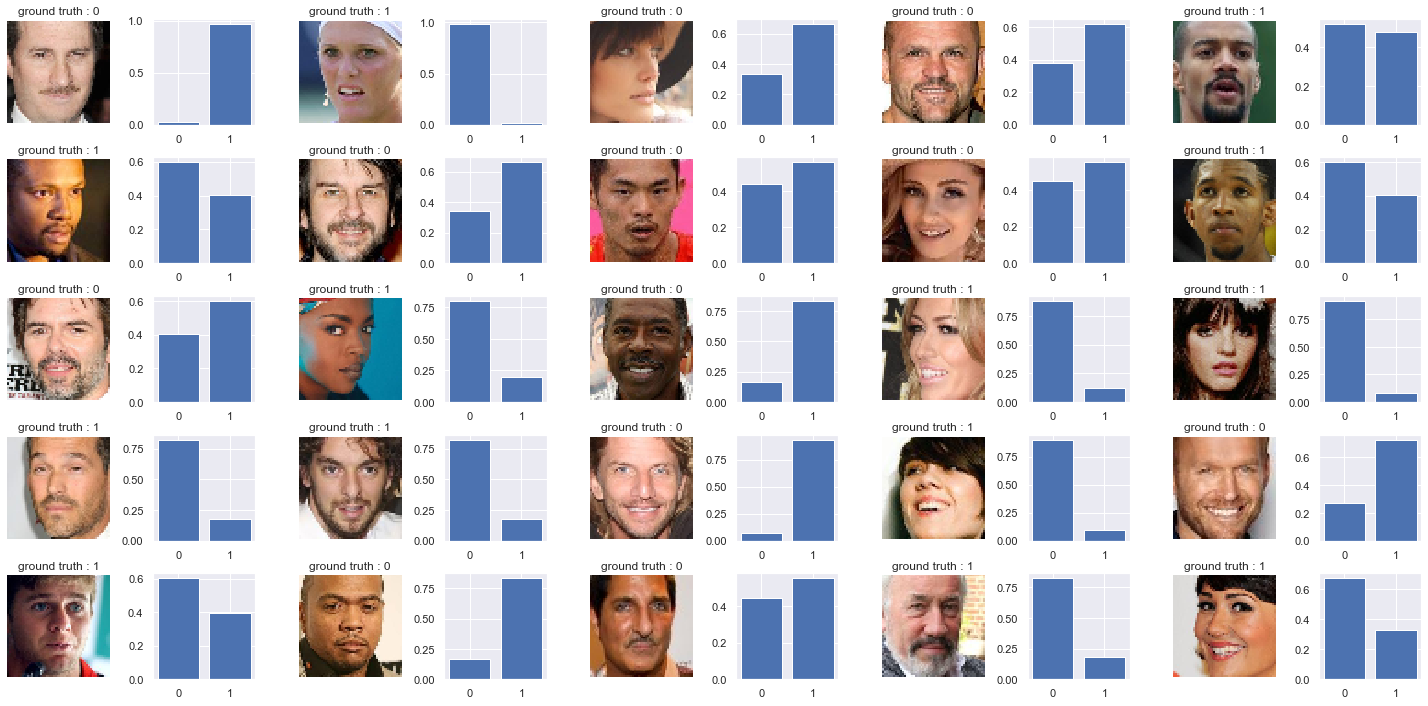

In [32]:
arg_wrong_predictions = [i for i in range (len(y_pred)) if y_pred[i] != y_test[i]]

num_rows = 5
num_cols = 5
num_images = num_rows*num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plt.imshow(X_test[arg_wrong_predictions[i]])
    plt.axis('off')
    plt.title('ground truth : {}'.format(y_test[arg_wrong_predictions[i]]))
    
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plt.bar(x=[0,1], height=predictions[arg_wrong_predictions[i]])
plt.tight_layout()
plt.show()

Observation :

For some images, the accessory (for example a hat) represents a very small portion of the image.<br/>
We can also observe that there's quite a lot of people from minorities. We can assume that the representation of all the different demographics is not uniform in the dataset, and some hidden bias may have appeared (light/dark people, male/female, ...)

Very interesting MIT lab about the topic, using a Variational AutoEncoder (VAE) : [notebook on my github repo](https://github.com/luisdossantos/mooc-mit-deeplearning/blob/master/Lab%202%20-%20Computer%20Vision/Part2_Debiasing.ipynb) / [scientific paper from Alexander Amini et al.](http://introtodeeplearning.com/AAAI_MitigatingAlgorithmicBias.pdf)

### predictions on the 'real' test set

In [33]:
predictions_test_set = cnn_model.predict(images_test)

# y_pred_test_set = [1 if predictions_test_set[i][1]>0.65 else 0 for i in range (len(predictions_test_set))]
# OR
y_pred_test_set = np.argmax(predictions_test_set, axis=1)

assert len(y_pred_test_set)==N_IMAGES_TEST, "y_pred_test_set should contain {} elements, as the test set contains {} images".format(N_IMAGES_TEST,N_IMAGES_TEST)

# create prediction.txt
create_pred_txt(y_pred_test_set)